# Data processing in Python - Project

## Spatial Autocorrelation in Regional Covid Incidence

### Heriberto Castilla, Jan Provazník

## 1 Load data
https://opendata.ecdc.europa.eu/covid19/subnationalcaseweekly/csv

In [69]:
# Load Data
import pandas as pd
url ="https://opendata.ecdc.europa.eu/covid19/subnationalcaseweekly/csv"
df = pd.read_csv(url, sep=',')

# Load the daily data too:
daily = pd.read_csv('C:/Users/jenda/Documents/B Škola/Semestr 12/IES Data Processing/data.csv')

## 2 Visualize data

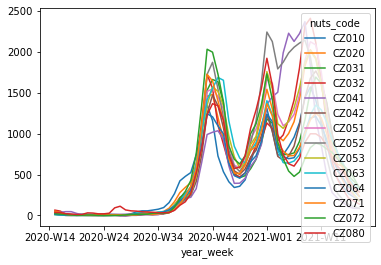

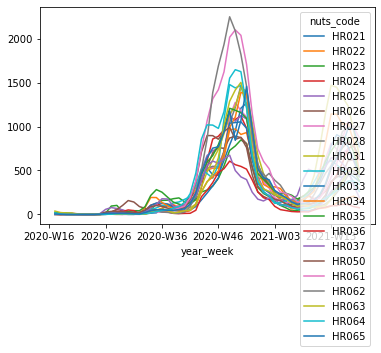

In [21]:
# slice data from Czech regions as an example
df_cz = df.loc[df['country'] == 'Czechia']
df_cz = df_cz.pivot(index='year_week', columns='nuts_code', values='rate_14_day_per_100k')
df_cz.plot()


# create a function that inputs country name and outputs this graphic
def country_plot(country):
    df_country= df.loc[df['country'] == country]
    df_country = df_country.pivot(index='year_week', columns='nuts_code', values='rate_14_day_per_100k')
    df_country.plot()

country_plot('Croatia')




## 3 Load shapefile

In [30]:
import geopandas as gpd
import gdal
import shapely
import matplotlib.pyplot as plt
import descartes

shapefile = gpd.read_file('C:/Users/jenda/Documents/B Škola/Semestr 12/IES Data Processing/NUTS')

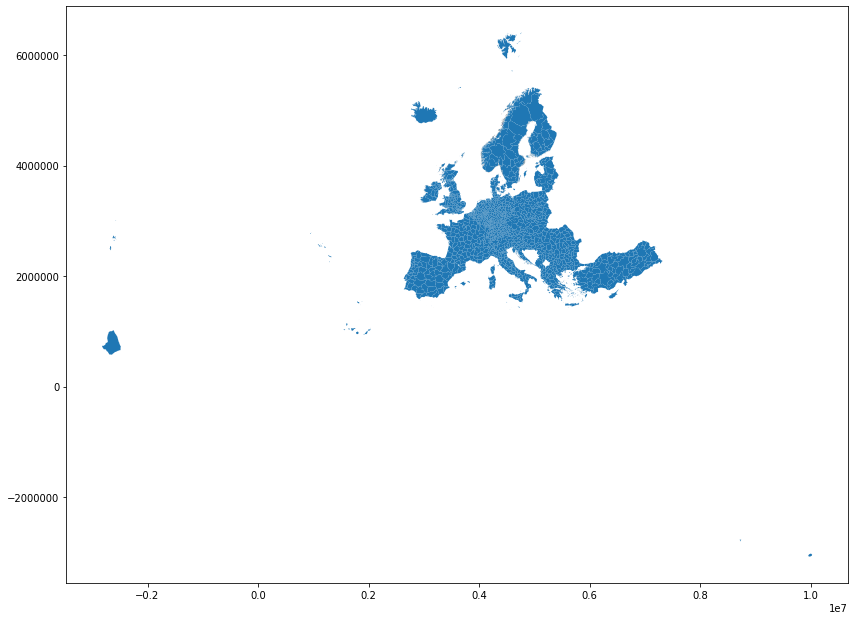

In [31]:
shapefile.plot(figsize=(14, 15))
plt.show()

In [32]:
print(shapefile.head())

  NUTS_ID  LEVL_CODE CNTR_CODE                     NAME_LATN  \
0   NO0B2          3        NO                      Svalbard   
1   NO0B1          3        NO          Jan Mayen\r\n   \r\n   
2   HR064          3        HR  Krapinsko-zagorska Å¾upanija   
3   DE21A          3        DE                        Erding   
4   DE94E          3        DE         OsnabrÃ¼ck, Landkreis   

                      NUTS_NAME  MOUNT_TYPE  URBN_TYPE  COAST_TYPE    FID  \
0                      Svalbard         3.0        3.0           1  NO0B2   
1          Jan Mayen\r\n   \r\n         NaN        NaN           1  NO0B1   
2  Krapinsko-zagorska Å¾upanija         4.0        3.0           3  HR064   
3                        Erding         4.0        3.0           3  DE21A   
4         OsnabrÃ¼ck, Landkreis         4.0        2.0           3  DE94E   

                                            geometry  
0  MULTIPOLYGON (((4760536.161 6404487.632, 47607...  
1  POLYGON ((3673081.665 5420781.907, 3673

In [33]:
shapefile["CNTR_CODE"].unique()

array(['NO', 'HR', 'DE', 'AL', 'BE', 'AT', 'ES', 'BG', 'FR', 'CZ', 'HU',
       'EL', 'FI', 'CH', 'CY', 'DK', 'EE', 'NL', 'IS', 'LV', 'MK', 'MT',
       'LT', 'IT', 'RS', 'PT', 'ME', 'PL', 'SE', 'IE', 'LU', 'RO', 'TR',
       'UK', 'LI', 'SK', 'SI'], dtype=object)

In [59]:
nuty_v_datech = [i for i in daily['nuts_code'].unique()]

In [61]:
vyber = [i for i in shapefile['NUTS_ID'].unique() if i in nuty_v_datech]

In [62]:
len(vyber)

622

In [45]:
daily.head()

,country,region_name,nuts_code,date,rate_14_day_per_100k,source
0,Austria,Mittelburgenland,AT111,2020-03-18,NaN,"TESSy COVID-19, subnational daily data"
1,Austria,Mittelburgenland,AT111,2020-03-19,NaN,"TESSy COVID-19, subnational daily data"
2,Austria,Mittelburgenland,AT111,2020-03-20,NaN,"TESSy COVID-19, subnational daily data"
3,Austria,Mittelburgenland,AT111,2020-03-21,NaN,"TESSy COVID-19, subnational daily data"
4,Austria,Mittelburgenland,AT111,2020-03-22,NaN,"TESSy COVID-19, subnational daily data"


In [70]:
daily['nuts_code'].unique()

array(['AT111', 'AT112', 'AT113', 'AT121', 'AT122', 'AT123', 'AT124',
       'AT125', 'AT126', 'AT127', 'AT130', 'AT211', 'AT212', 'AT213',
       'AT221', 'AT222', 'AT223', 'AT224', 'AT225', 'AT226', 'AT311',
       'AT312', 'AT313', 'AT314', 'AT315', 'AT321', 'AT322', 'AT323',
       'AT331', 'AT332', 'AT333', 'AT334', 'AT335', 'AT341', 'AT342',
       'DK011', 'DK012', 'DK013', 'DK014', 'DK021', 'DK022', 'DK031',
       'DK032', 'DK041', 'DK042', 'DK050', 'FI193', 'FI194', 'FI195',
       'FI196', 'FI197', 'FI1B1', 'FI1C1', 'FI1C2', 'FI1C3', 'FI1C4',
       'FI1C5', 'FI1D1', 'FI1D2', 'FI1D3', 'FI1D5', 'FI1D7', 'FI1D8',
       'FI1D9', 'FI200', 'DE111', 'DE112', 'DE113', 'DE114', 'DE115',
       'DE116', 'DE117', 'DE118', 'DE119', 'DE11A', 'DE11B', 'DE11C',
       'DE11D', 'DE121', 'DE122', 'DE123', 'DE124', 'DE125', 'DE126',
       'DE127', 'DE128', 'DE129', 'DE12A', 'DE12B', 'DE12C', 'DE131',
       'DE132', 'DE133', 'DE134', 'DE135', 'DE136', 'DE137', 'DE138',
       'DE139', 'DE1

In [68]:
shapefile['NUTS_ID'].unique()

array(['NO0B2', 'NO0B1', 'HR064', ..., 'UKM76', 'UKM78', 'UKK24'],
      dtype=object)

In [38]:
codes = ['AT', 'BE', 'BG', 'HR', 'CY', 'CZ', 'DK', 'EE', 'FI', 'FR', 'DE', 'GR', 'HU', 'IS', 'IE', 'IT', 'LV', 'LI', 'LT', 'LU', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO', 'SK', 'SI', 'ES', 'SE']

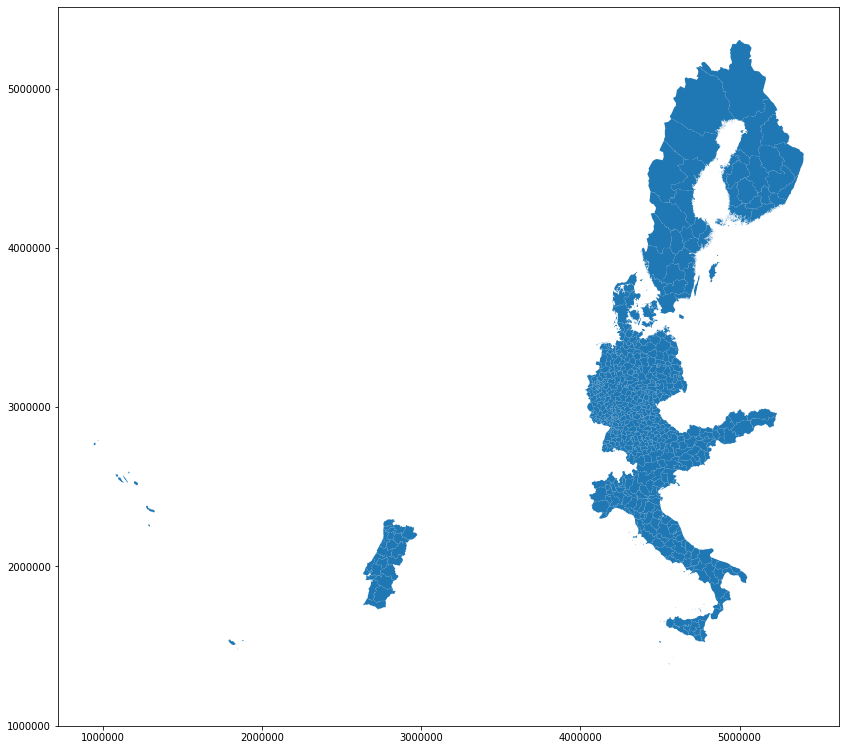

In [71]:
vyber = shapefile[shapefile['FID'].isin(daily['nuts_code'].unique())]
vyber.plot(figsize=(14, 15))
plt.show()

## 4 Generate weight matrix

## 5 Calculate Moran's I from the data and the matrix

## 6 Visualize Moran's I time series

Here we will visualize the Moran's I time series in a plot. We don't have the series yet, so let's generate a random one for now and visualize it and then at the end, when the series is finally obtained, we will just substitute it in the plot.

In [11]:
#here I generate some kinda random time series y

import numpy as np
import pandas as pd

y = [0]*400
for i in range(1,400):
    y[i] = 0.5*y[i-1] + np.random.normal(loc=0.0, scale=1.0, size=None)
y = pd.DataFrame(y)

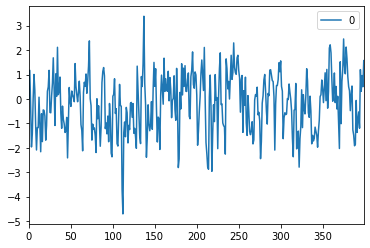

In [14]:
#make a plot of y:
y.plot()